[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/troelspetersen/AppliedML2025_InstructorsFolder/blob/main/Week4/nano_GPT.ipynb)

# Building a Character-Level Shakespearean Transformer (nano-GPT)

Welcome to this hands-on exercise where we'll build and train a miniature version of a Generative Pre-trained Transformer (GPT) model.

This notebook is heavily inspired by and simplifies Andrej Karpathy's fantastic [nanoGPT repository](https://github.com/karpathy/nanoGPT). Our goal is to strip down the complexity to the bare essentials needed to understand the core concepts and train a character-level language model on the works of Shakespeare.

**Why is this exciting?**
The Transformer architecture, which we'll be implementing, is the foundation of modern Large Language Models (LLMs). While our model will be much smaller, the fundamental building blocks (like self-attention, positional embeddings, and decoder blocks) are conceptually very similar to those in models like GPT-3, which powered the original ChatGPT. By building this "baby GPT," you'll gain a much deeper intuition for how these incredible models work.

**What we'll do:**
1.  **Data Preparation:** Load Shakespeare's text and create a character-level tokenizer.
2.  **Model Definition:** Implement the GPT architecture from scratch, including self-attention and transformer blocks.
3.  **Training:** Write a simple training loop to teach our model to predict the next character in a sequence.
4.  **Generation:** Use our trained model to generate new, Shakespeare-like text.

Make sure your Colab runtime is set to use a GPU for faster training (Runtime -> Change runtime type -> GPU).

In [1]:
import os
import requests
import time
import math
from dataclasses import dataclass
import pickle # For saving/loading meta later if needed, though not strictly for tokenizer now

import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm # For progress bars

# --- Hyperparameters ---
BATCH_SIZE = 64
BLOCK_SIZE = 256  # Context length
MAX_ITERS = 5000
EVAL_INTERVAL = 250
LEARNING_RATE = 3e-4 # Adjusted from 1e-3, often 3e-4 is a good starting point
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EMBD = 384
N_HEAD = 6
N_LAYER = 6
DROPOUT = 0.2
# AdamW optimizer betas
BETA1 = 0.9
BETA2 = 0.95
# Early stopping
EARLY_STOPPING_PATIENCE = 5 # Number of evaluation intervals to wait
EVAL_ITERS_FOR_LOSS = 100 # Number of batches to average for loss estimation

# For reproducibility
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)

print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Data Loading and Tokenization

The first step in any machine learning project is to prepare the data. For our character-level language model, this involves:
1.  **Downloading the Data:** We'll use the "Tiny Shakespeare" dataset, which contains a collection of Shakespeare's works.
2.  **Creating a Vocabulary:** We'll identify all unique characters present in the text. This set of unique characters will form our vocabulary.
3.  **Building a Tokenizer:** We'll create two simple functions:
    *   `encode`: Converts a string of characters into a list of corresponding integer IDs (tokens).
    *   `decode`: Converts a list of integer IDs back into a string of characters.
4.  **Splitting the Data:** We'll divide the dataset into a training set (for teaching the model) and a validation set (for evaluating its performance on unseen data).

In [2]:
# --- 1. Data Loading and Tokenization ---
input_file_path = 'input.txt'
data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

if not os.path.exists(input_file_path):
    print(f"Downloading {input_file_path}...")
    with open(input_file_path, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)
    print("Download complete.")
else:
    print(f"{input_file_path} already exists.")

with open(input_file_path, 'r', encoding='utf-8') as f:
    data = f.read()
print(f"Length of dataset in characters: {len(data):,}")

# Get all unique characters
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("All unique characters:", ''.join(chars))
print(f"Vocabulary size: {vocab_size:,}")

# Create mappings from characters to integers and vice-versa
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# Encoder: take a string, output a list of integers
def encode(s):
    return [stoi[c] for c in s]

# Decoder: take a list of integers, output a string
def decode(l):
    return ''.join([itos[i] for i in l])

# Create train and validation splits
n = len(data)
train_text = data[:int(n * 0.9)]
val_text = data[int(n * 0.9):]

# Encode the text and convert to PyTorch tensors
train_data = torch.tensor(encode(train_text), dtype=torch.long)
val_data = torch.tensor(encode(val_text), dtype=torch.long)

print(f"Train data has {len(train_data):,} tokens")
print(f"Validation data has {len(val_data):,} tokens")

input.txt already exists.
Length of dataset in characters: 1,115,394
All unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65
Train data has 1,003,854 tokens
Validation data has 111,540 tokens


In [3]:
# --- Tokenizer Experimentation ---
sample_text = "Hello, World! This is a test."
print(f"Original text: '{sample_text}'")

encoded_sample = encode(sample_text)
print(f"Encoded text: {encoded_sample}")

decoded_sample = decode(encoded_sample)
print(f"Decoded text: '{decoded_sample}'")

assert sample_text == decoded_sample, "Encoding/Decoding mismatch!"
print("Tokenizer test passed!")

Original text: 'Hello, World! This is a test.'
Encoded text: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2, 1, 32, 46, 47, 57, 1, 47, 57, 1, 39, 1, 58, 43, 57, 58, 8]
Decoded text: 'Hello, World! This is a test.'
Tokenizer test passed!


In [4]:
# --- Data Loader ---
def get_batch(split):
    # Selects the appropriate dataset (train or val)
    data_source = train_data if split == 'train' else val_data
    # Generates random starting indices for batch_size sequences
    ix = torch.randint(len(data_source) - BLOCK_SIZE, (BATCH_SIZE,))
    # Extracts input sequences (x)
    x = torch.stack([data_source[i:i+BLOCK_SIZE] for i in ix])
    # Extracts target sequences (y), which are shifted by one character
    y = torch.stack([data_source[i+1:i+BLOCK_SIZE+1] for i in ix])
    # Move data to the specified device (CPU or GPU)
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x, y

# Test get_batch
xb, yb = get_batch('train')
print("Input batch shape:", xb.shape)
print("Target batch shape:", yb.shape)
print("First sequence in input batch (first 30 tokens):", decode(xb[0][:30].tolist()))
print("First sequence in target batch (first 30 tokens):", decode(yb[0][:30].tolist()))

Input batch shape: torch.Size([64, 256])
Target batch shape: torch.Size([64, 256])
First sequence in input batch (first 30 tokens): 
Not Gloucester's death, nor H
First sequence in target batch (first 30 tokens): Not Gloucester's death, nor He


## 2. Model Definition: The Transformer Architecture

Now for the exciting part: building our GPT model! We'll implement the core components of the Transformer architecture, specifically the "decoder-only" variant used in GPT models.

Key components we will define:
*   **`GPTConfig`**: A dataclass to hold all our model hyperparameters (like vocabulary size, embedding dimension, number of layers, etc.).
*   **`LayerNorm`**: A normalization layer crucial for stabilizing training in deep networks.
*   **`CausalSelfAttention`**: The heart of the Transformer! This module allows each token in a sequence to "attend" to previous tokens (but not future ones, hence "causal") to understand context. We'll implement the scaled dot-product attention mechanism.
*   **`MLP` (Multi-Layer Perceptron)**: A simple feed-forward network applied after the attention mechanism in each Transformer block.
*   **`Block`**: A single Transformer block, which typically consists of a self-attention layer followed by an MLP, with residual connections and layer normalization.
*   **`GPT`**: The main model class that stacks multiple `Block`s, includes token and positional embeddings, and a final linear layer to predict the next token.

We'll also explore the model's output *before* any training to understand its initial (random) state and the expected initial loss.

In [5]:
# --- 2. Model Definition ---

@dataclass
class GPTConfig:
    block_size: int = BLOCK_SIZE
    vocab_size: int = vocab_size # Will be set by loaded data
    n_layer: int = N_LAYER
    n_head: int = N_HEAD
    n_embd: int = N_EMBD
    dropout: float = DROPOUT
    bias: bool = True # True: bias in Linears and LayerNorms

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. """
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # Causal mask to ensure that attention is only applied to the left in the input sequence
        # We use register_buffer for parameters that should be part of the model's state
        # but are not trained by the optimizer (e.g., a fixed mask).
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # Manual implementation of attention
        # (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # Apply causal mask
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C) # Re-assemble all head outputs side by side

        # Output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU() # Using GELU activation
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))  # Attention with residual connection
        x = x + self.mlp(self.ln_2(x))   # MLP with residual connection
        return x

In [6]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),      # Token embeddings
            wpe = nn.Embedding(config.block_size, config.n_embd),     # Positional embeddings
            drop = nn.Dropout(config.dropout),                        # Dropout layer
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # Transformer blocks
            ln_f = LayerNorm(config.n_embd, bias=config.bias),        # Final layer norm
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Language model head

        # Weight tying: token embeddings and final linear layer share weights
        self.transformer.wte.weight = self.lm_head.weight

        # Initialize weights
        self.apply(self._init_weights)
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Number of trainable parameters: {num_params/1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size() # Batch size, sequence length
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # Shape (t)

        # Forward the GPT model
        tok_emb = self.transformer.wte(idx) # Token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # Position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # If we are given some desired targets also calculate the loss
            logits = self.lm_head(x) # (b, t, vocab_size)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            # Inference-time optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # Note: using list [-1] to preserve the time dim -> (b, 1, vocab_size)
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        """
        self.eval() # Set model to evaluation mode
        for _ in range(max_new_tokens):
            # If the sequence context is growing too long, crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # Forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond) # Loss is None during generation
            # Pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # Optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf') # Mask non-top-k logits
            # Apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        self.train() # Set model back to training mode if used elsewhere
        return idx

In [7]:
# --- Model Initialization and Initial Exploration ---

# Create GPTConfig instance
model_config = GPTConfig(vocab_size=vocab_size, block_size=BLOCK_SIZE,
                         n_layer=N_LAYER, n_head=N_HEAD, n_embd=N_EMBD, dropout=DROPOUT)

# Instantiate the model
model = GPT(model_config)
model.to(DEVICE)

# Get a batch of data
xb, yb = get_batch('train')

print("--- Before Training ---")
# Pass the batch through the UNTRAINED model
logits, loss = model(xb, yb)

print("Logits shape:", logits.shape) # Should be (BATCH_SIZE, BLOCK_SIZE, vocab_size)
print("Initial loss:", loss.item())

# For a randomly initialized model, the loss should be roughly -ln(1/vocab_size)
# This is because the model initially assigns roughly equal probability to each token in the vocabulary.
# The cross-entropy loss for a uniform distribution over V classes is -sum( (1/V) * log(1/V) ) = -V * (1/V) * log(1/V) = -log(1/V) = log(V)
expected_loss = -math.log(1.0 / vocab_size)
print(f"Expected initial loss (approx -ln(1/vocab_size)): {expected_loss:.4f}")
# The actual initial loss will vary due to specific weight initialization but should be in this ballpark.

# Let's look at the logits for the first token prediction in the first sequence
first_token_logits = logits[0, 0, :]
print("Logits for the first token prediction in the first sequence (first 10 values):", first_token_logits[:10])
# These are raw, unnormalized scores for each possible next character.
# After softmax, these would turn into probabilities.

Number of trainable parameters: 10.77M
--- Before Training ---
Logits shape: torch.Size([64, 256, 65])
Initial loss: 4.285391330718994
Expected initial loss (approx -ln(1/vocab_size)): 4.1744
Logits for the first token prediction in the first sequence (first 10 values): tensor([ 0.0880, -1.0848,  0.1741,  0.4192, -0.1020, -0.2917, -0.1435, -0.2548,
        -0.5986,  0.0692], device='cuda:0', grad_fn=<SliceBackward0>)


In [8]:
# --- Evaluation Function ---
@torch.no_grad() # Decorator to disable gradient calculations during evaluation
def estimate_loss(model_to_eval):
    out = {}
    model_to_eval.eval() # Set the model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS_FOR_LOSS) # Array to store losses for averaging
        for k in range(EVAL_ITERS_FOR_LOSS):
            X, Y = get_batch(split)
            _, current_loss = model_to_eval(X, Y)
            losses[k] = current_loss.item()
        out[split] = losses.mean() # Average loss over EVAL_ITERS_FOR_LOSS batches
    model_to_eval.train() # Set the model back to training mode
    return out

## 3. Training the Model

With our data prepared and model defined, it's time to train! The training process involves:
1.  **Loss Estimation:** We'll define a helper function (`estimate_loss`) to calculate the model's performance (cross-entropy loss) on both the training and validation sets without updating its weights. This helps us monitor learning and detect overfitting.
2.  **Optimizer:** We'll use the AdamW optimizer, a common choice for training Transformers.
3.  **Training Loop:**
    *   Repeatedly sample batches of data.
    *   Perform a **forward pass**: Feed the input batch to the model to get predictions (logits) and calculate the loss.
    *   Perform a **backward pass**: Calculate gradients of the loss with respect to the model's parameters.
    *   **Update parameters**: Adjust the model's weights using the optimizer to minimize the loss.
4.  **Evaluation & Checkpointing:** Periodically, we'll evaluate the model on the validation set. If the validation loss improves, we'll save a "checkpoint" of the model's weights.
5.  **Early Stopping:** If the validation loss stops improving for a certain number of evaluations, we'll stop training to prevent overfitting.

We'll use `tqdm` to display a progress bar during training.

In [9]:
# --- 3. Training Loop ---
print(f"Starting training on {DEVICE}...")

# Optimizer (AdamW is a common choice for transformers)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

best_val_loss = float('inf')
epochs_no_improve = 0
train_loss_history = []
val_loss_history = []
iter_history = []

# For timing
overall_start_time = time.time()

# Wrap the main loop with tqdm for a progress bar
for iter_num in tqdm(range(MAX_ITERS), desc="Training Progress"):
    # iter_start_time = time.time() # tqdm provides timing per iteration

    # Every EVAL_INTERVAL, estimate loss on train and val sets
    if iter_num % EVAL_INTERVAL == 0 or iter_num == MAX_ITERS - 1:
        losses = estimate_loss(model) # This already sets model.eval() and model.train()
        train_loss_history.append(losses['train'].item())
        val_loss_history.append(losses['val'].item())
        iter_history.append(iter_num)

        # tqdm will show iteration/s, so manual timing print might be redundant
        # elapsed_iter_time = time.time() - iter_start_time
        # print(f"Step {iter_num}: Train loss {losses['train']:.4f}, Val loss {losses['val']:.4f}, Iter time: {elapsed_iter_time:.2f}s")

        # Log to tqdm's postfix
        tqdm.write(f"Step {iter_num:5d}: Train loss {losses['train']:.4f}, Val loss {losses['val']:.4f}")


        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            epochs_no_improve = 0
            # Save the best model checkpoint to the Colab instance's local storage
            # This file will be lost if the Colab runtime is disconnected or reset unless moved.
            torch.save(model.state_dict(), 'best_shakespeare_model.pth')
            tqdm.write(f"  -> New best validation loss: {best_val_loss:.4f}. Model saved to best_shakespeare_model.pth")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            tqdm.write(f"Early stopping triggered at iteration {iter_num} after {EARLY_STOPPING_PATIENCE} evaluation intervals without improvement.")
            break # Exit the training loop

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Forward pass: evaluate loss
    logits, loss = model(xb, yb)

    # Backward pass and optimization step
    optimizer.zero_grad(set_to_none=True) # Zero out gradients from previous iteration
    loss.backward()                       # Compute gradients
    optimizer.step()                      # Update model parameters

overall_end_time = time.time()
print(f"--- Training Finished ---")
print(f"Total training time: {(overall_end_time - overall_start_time)/60:.2f} minutes")
print(f"Best validation loss achieved: {best_val_loss:.4f}")

# Load the best model weights after training is complete (or early stopped)
# This ensures the 'model' variable holds the best performing weights for generation.
if os.path.exists('best_shakespeare_model.pth'):
    print("Loading best model weights for generation...")
    model.load_state_dict(torch.load('best_shakespeare_model.pth', map_location=DEVICE))
else:
    print("Warning: No 'best_shakespeare_model.pth' found. Using current model state (likely the last trained state) for generation.")

Starting training on cuda...


Training Progress:   0%|          | 0/5000 [00:32<?, ?it/s]

Step     0: Train loss 4.2999, Val loss 4.3001
  -> New best validation loss: 4.3001. Model saved to best_shakespeare_model.pth


Training Progress:   5%|▌         | 251/5000 [03:01<13:26:53, 10.19s/it]

Step   250: Train loss 2.3349, Val loss 2.3687
  -> New best validation loss: 2.3687. Model saved to best_shakespeare_model.pth


Training Progress:  10%|█         | 501/5000 [05:29<12:45:03, 10.20s/it]

Step   500: Train loss 1.8924, Val loss 2.0067
  -> New best validation loss: 2.0067. Model saved to best_shakespeare_model.pth


Training Progress:  15%|█▌        | 751/5000 [07:57<12:02:14, 10.20s/it]

Step   750: Train loss 1.6438, Val loss 1.8208
  -> New best validation loss: 1.8208. Model saved to best_shakespeare_model.pth


Training Progress:  20%|██        | 1001/5000 [10:26<11:19:59, 10.20s/it]

Step  1000: Train loss 1.4985, Val loss 1.6962
  -> New best validation loss: 1.6962. Model saved to best_shakespeare_model.pth


Training Progress:  25%|██▌       | 1251/5000 [12:54<10:37:33, 10.20s/it]

Step  1250: Train loss 1.4084, Val loss 1.6153
  -> New best validation loss: 1.6153. Model saved to best_shakespeare_model.pth


Training Progress:  30%|███       | 1501/5000 [15:22<9:54:52, 10.20s/it]

Step  1500: Train loss 1.3477, Val loss 1.5790
  -> New best validation loss: 1.5790. Model saved to best_shakespeare_model.pth


Training Progress:  35%|███▌      | 1751/5000 [17:51<9:12:26, 10.20s/it]

Step  1750: Train loss 1.2908, Val loss 1.5349
  -> New best validation loss: 1.5349. Model saved to best_shakespeare_model.pth


Training Progress:  40%|████      | 2001/5000 [20:20<8:29:33, 10.19s/it]

Step  2000: Train loss 1.2481, Val loss 1.5075
  -> New best validation loss: 1.5075. Model saved to best_shakespeare_model.pth


Training Progress:  45%|████▌     | 2251/5000 [22:48<7:47:32, 10.20s/it]

Step  2250: Train loss 1.2072, Val loss 1.5006
  -> New best validation loss: 1.5006. Model saved to best_shakespeare_model.pth


Training Progress:  50%|█████     | 2501/5000 [25:16<7:04:54, 10.20s/it]

Step  2500: Train loss 1.1751, Val loss 1.4952
  -> New best validation loss: 1.4952. Model saved to best_shakespeare_model.pth


Training Progress:  55%|█████▌    | 2751/5000 [27:45<6:22:27, 10.20s/it]

Step  2750: Train loss 1.1429, Val loss 1.4878
  -> New best validation loss: 1.4878. Model saved to best_shakespeare_model.pth


Training Progress:  60%|██████    | 3001/5000 [30:14<5:40:34, 10.22s/it]

Step  3000: Train loss 1.1121, Val loss 1.4823
  -> New best validation loss: 1.4823. Model saved to best_shakespeare_model.pth


Training Progress:  65%|██████▌   | 3251/5000 [32:42<4:56:41, 10.18s/it]

Step  3250: Train loss 1.0786, Val loss 1.4898


Training Progress:  70%|███████   | 3501/5000 [35:11<4:14:40, 10.19s/it]

Step  3500: Train loss 1.0450, Val loss 1.4814
  -> New best validation loss: 1.4814. Model saved to best_shakespeare_model.pth


Training Progress:  75%|███████▌  | 3751/5000 [37:39<3:32:04, 10.19s/it]

Step  3750: Train loss 1.0180, Val loss 1.4886


Training Progress:  80%|████████  | 4001/5000 [40:08<2:49:13, 10.16s/it]

Step  4000: Train loss 0.9872, Val loss 1.5047


Training Progress:  85%|████████▌ | 4251/5000 [42:36<2:07:04, 10.18s/it]

Step  4250: Train loss 0.9589, Val loss 1.5163


Training Progress:  90%|█████████ | 4501/5000 [45:05<1:24:37, 10.18s/it]

Step  4500: Train loss 0.9287, Val loss 1.5233


Training Progress:  95%|█████████▌| 4750/5000 [47:33<02:30,  1.66it/s]

Step  4750: Train loss 0.8995, Val loss 1.5485
Early stopping triggered at iteration 4750 after 5 evaluation intervals without improvement.
--- Training Finished ---
Total training time: 47.56 minutes
Best validation loss achieved: 1.4814
Loading best model weights for generation...


## 4. Generating Text with the Trained Model

After training (or loading our best checkpoint), our model should have learned the patterns and style of Shakespearean English. Now, we can use it as a generative model:
1.  **Provide a Prompt:** We'll give the model a starting sequence of characters (a "prompt").
2.  **Predict Next Character:** The model will predict the probability distribution for the next character.
3.  **Sample:** We'll sample a character from this distribution (we can use `temperature` to control randomness and `top_k` to limit choices).
4.  **Append and Repeat:** Append the sampled character to our sequence and feed the new, longer sequence back into the model to generate the next character. We repeat this process to generate new text.

Let's see if our model can write some "new" Shakespeare!

In [10]:
# --- 4. Generate Text ---
print(f"\n--- Generating Shakespeare-like text ---")

# You can change the starting prompt
start_string = "JULIET:\nO Romeo, Romeo! wherefore art thou Romeo?\n"
# start_string = "To be, or not to be, that is the question:\n"
# start_string = "The king is dead"

print(f"Starting prompt: '{start_string.strip()}'")

start_ids = encode(start_string)
# Unsqueeze to add batch dimension: (seq_len) -> (1, seq_len)
x_input = torch.tensor(start_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

# Generate text
model.eval() # Set model to evaluation mode for generation
with torch.no_grad(): # No need to track gradients during generation
    generated_ids = model.generate(x_input,
                                   max_new_tokens=1000,
                                   temperature=0.8, # Controls randomness: lower is less random, higher is more random
                                   top_k=20)       # Considers only the top_k most likely tokens at each step

generated_text = decode(generated_ids[0].tolist()) # Decode the first (and only) batch item
print("\n--- Generated Text ---")
print(generated_text)


--- Generating Shakespeare-like text ---
Starting prompt: 'JULIET:
O Romeo, Romeo! wherefore art thou Romeo?'

--- Generated Text ---
JULIET:
O Romeo, Romeo! wherefore art thou Romeo?
Arise that thy dead cannot live and me?
And like a careerful mother and these fight.

JULIET:
Was this it with thee? why, thou not likege, what'st thus
Thy art disguised out of this death of my good?
And so I disguised him to make me a king;
And I am his care in power to see his wife
To avoid the morning standing of his death.
And now, faith, in his head charge him, sir,
The pretty is not being to me again.

EDWARD:
Are you are his open sort must not arm.

Second Watchman:
I love a corse: the senators that waxed
From me to suppose our foe: for him, being still,
A man, like a man in honour'd of marriage,
Which may see the treasure of your trial,
Or else not produce home in his king's;
For the worthy earth her lives wound his head,
His brother to her was contented next,
And all a tired courses where we giv

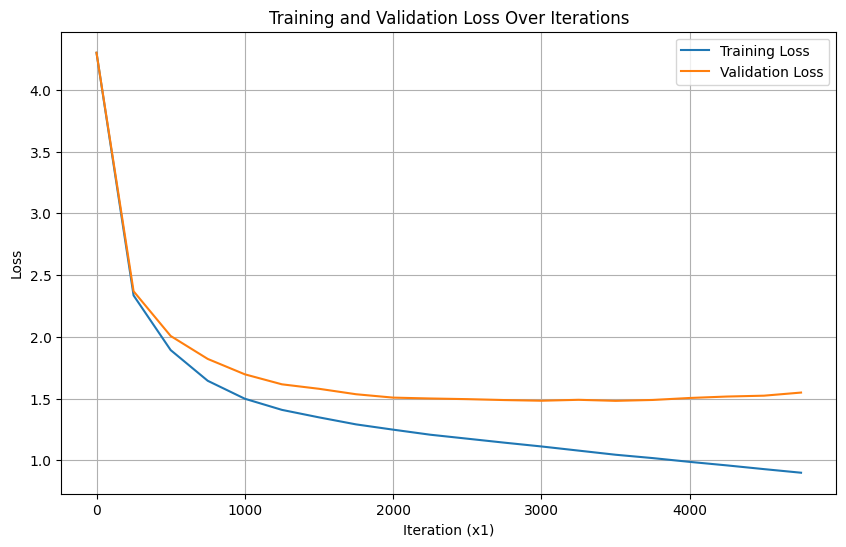

In [11]:
import matplotlib.pyplot as plt

if train_loss_history and val_loss_history:
    plt.figure(figsize=(10, 6))
    plt.plot(iter_history, train_loss_history, label='Training Loss')
    plt.plot(iter_history, val_loss_history, label='Validation Loss')
    plt.xlabel(f'Iteration (x{1})') # Since iter_history stores actual iteration numbers
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No loss history to plot. Did training run?")

## Congratulations and Further Exploration!

You've successfully built, trained, and generated text with a character-level GPT model! This is a significant achievement and provides a solid foundation for understanding modern Large Language Models.

Here are some exercises and avenues for further exploration to deepen your understanding:

**1. Deep Dive into the Code:**
    *   **Meticulously study the `CausalSelfAttention`, `Block`, and `GPT` classes.** Add print statements inside their `forward` methods to trace the shapes of tensors at each step.
    *   **Understand every line:** If any line of code is unclear, research it or ask! Pay close attention to tensor manipulations (e.g., `view`, `transpose`, `@` for matrix multiplication).

**2. Tensor Shapes and Outputs:**
    *   Before and during training, **print out the shapes** of `q`, `k`, `v`, and `att` in the `CausalSelfAttention` module. How do they relate to `BATCH_SIZE`, `BLOCK_SIZE`, `N_HEAD`, and `N_EMBD`?
    *   Examine the `logits` output by the model. What does `logits.shape` tell you? How does `F.cross_entropy` use these logits and the target `yb`?
    *   What happens if you change `BLOCK_SIZE`? How does it affect memory and the model's "context window"?

**3. The Magic of Attention (Advanced):**
    *   **Extract Attention Weights:** After training, try to visualize or inspect the attention weights. For a given input sequence, which previous tokens does a particular token "attend" to most strongly?
        *Hint:* The `att` variable inside `CausalSelfAttention.forward` (after `softmax`) holds the attention probabilities. You'll need to run a forward pass with a specific input and capture this tensor.
        ```python
        # Example: How to potentially get attention weights for a specific layer/head
        # model.eval()
        # xb_sample, _ = get_batch('val') # Get a sample batch
        # specific_block = model.transformer.h[0].attn # e.g., attention in the first block
        
        # To get 'att' you might need to modify CausalSelfAttention to return it,
        # or use PyTorch hooks (more advanced).
        # A simpler way for inspection is to add a temporary print inside forward:
        # if some_condition_to_print: print(att[0, 0, :, :].detach().cpu().numpy()) # Example for 1st batch, 1st head
        ```
    *   **(Challenge):** Try to implement a simplified version of the scaled dot-product attention mechanism (`(Q @ K.T) / sqrt(d_k)`) yourself as a standalone function using basic PyTorch tensor operations. Compare its output for a sample Q, K, V with the `att @ v` part of the `CausalSelfAttention` module (before dropout and projection).

**4. Hyperparameter Tuning:**
    *   Experiment with `LEARNING_RATE`, `N_LAYER`, `N_HEAD`, `N_EMBD`, `DROPOUT`. How do these changes affect training speed, final validation loss, and the quality of generated text?
    *   What happens if you significantly increase `MAX_ITERS` (and adjust `EARLY_STOPPING_PATIENCE` if needed)? Can you get a lower validation loss? (Be mindful of Colab time limits).
    *   Try different `temperature` and `top_k` values during generation. How does it change the output?

**5. Beyond Characters:**
    *   Conceptually, how would you adapt this model to work with words or sub-word units instead of characters? What parts of the code would need to change significantly? (This is a big step, more for conceptual understanding).

**6. Come Up With More Exercises!**
    *   What other aspects of the model or training process are you curious about? Design an experiment to investigate it! For example:
        *   How does weight initialization affect training?
        *   What if you remove positional embeddings?
        *   Can you train on a different small text dataset?



## Bonus: Saving and Loading Your Trained Model

During training, our script saves the best performing model (based on validation loss) to a file named `best_shakespeare_model.pth` in the current Colab session's temporary storage.

**Important:** Files saved directly in the Colab environment are temporary and will be **deleted** when your Colab runtime is disconnected or reset.

Here's how you can permanently save your model and load it back:

#### Option 1: Downloading the Model to Your Local Computer

Once training is complete and `best_shakespeare_model.pth` has been saved by the script:

1.  **Locate the File:** In the Colab interface, click on the "Files" icon (looks like a folder) in the left sidebar. You should see `best_shakespeare_model.pth` listed.
2.  **Download:** Right-click on `best_shakespeare_model.pth` and select "Download". The file will be saved to your computer's default downloads folder.

To load this model back into a *new* Colab session (or on your local machine if you have PyTorch set up):
1.  Upload the `.pth` file back to the Colab session (using the "Upload to session storage" button in the Files tab).
2.  Then, in your code, you can load it (make sure your model architecture is defined first):
    ```python
    # # --- Code to define the GPT model and GPTConfig must be run first ---
    # model_config = GPTConfig(vocab_size=vocab_size, ...) # Use the same config as training
    # model = GPT(model_config)
    # model.to(DEVICE)
    #
    # # Load the state dictionary
    # model_path = 'best_shakespeare_model.pth' # Or whatever you named it when uploading
    # if os.path.exists(model_path):
    #     model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    #     model.eval() # Set to evaluation mode
    #     print(f"Model loaded from {model_path}")
    # else:
    #     print(f"Model file not found at {model_path}")
    ```

#### Option 2 (untested!): Saving the Model to Your Google Drive

This is a more robust way to save your model for long-term storage and easy access across Colab sessions.

1.  **Mount Your Google Drive:**
    Run the following code in a cell. You'll be prompted to authorize Colab to access your Google Drive.
    ```python
    from google.colab import drive
    drive.mount('/content/drive')
    ```

2.  **Define a Save Path on Your Drive:**
    Choose a folder and filename on your Google Drive. It's good practice to create a specific folder for your models.
    ```python
    # Example save path (modify as needed)
    # This will save to a folder named 'MyModels' in the root of your Google Drive.
    # Make sure the 'MyModels' folder exists, or create it.
    drive_save_path = '/content/drive/MyDrive/MyModels/best_shakespeare_char_gpt.pth'
    
    # You might want to create the directory if it doesn't exist:
    # import os
    # os.makedirs(os.path.dirname(drive_save_path), exist_ok=True)
    ```

3.  **Modify the Training Loop to Save to Drive (or Save Manually After Training):**
    *   **To save during training:** In Cell 9 (Training Loop), change the line:
        `torch.save(model.state_dict(), 'best_shakespeare_model.pth')`
        to:
        `torch.save(model.state_dict(), drive_save_path)`
    *   **To save manually after training is complete:**
        ```python
        # # Assuming 'model' is your trained model and 'drive_save_path' is defined
        # torch.save(model.state_dict(), drive_save_path)
        # print(f"Model saved to Google Drive: {drive_save_path}")
        ```

4.  **Loading the Model from Google Drive:**
    In a new session, after mounting your Drive and defining your model architecture:
    ```python
    # # --- Mount Drive and define model architecture first ---
    # from google.colab import drive
    # drive.mount('/content/drive')
    #
    # # model_config = GPTConfig(vocab_size=vocab_size, ...)
    # # model = GPT(model_config)
    # # model.to(DEVICE)
    #
    # drive_model_path = '/content/drive/MyDrive/MyModels/best_shakespeare_char_gpt.pth' # Use the same path
    # if os.path.exists(drive_model_path):
    #     model.load_state_dict(torch.load(drive_model_path, map_location=DEVICE))
    #     model.eval() # Set to evaluation mode
    #     print(f"Model loaded from Google Drive: {drive_model_path}")
    # else:
    #     print(f"Model file not found at {drive_model_path}")
    ```

